In [1]:
!pip install loglizer

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


## Data Exploration

In [2]:
import pandas as pd
import re
import sys
sys.path.append('../')
from loglizer.models import LogClustering
from loglizer import dataloader, preprocessing
import itertools

In [3]:
feature_path = 'data/HDFS_100k.log_structured.csv'
label_path = 'data/anomaly_label.csv'

In [4]:
# load HDFS logs into pandas DataFrame
feature_df = pd.read_csv(feature_path)
print(feature_df.shape)
feature_df.head()

(104815, 9)


,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
1,2,81109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>
2,3,81109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
3,4,81109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
4,5,81109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,E11,PacketResponder <*> for block <*> terminating


In [5]:
# Check for missing values
print( feature_df.isnull().any().sum() )

0


In [6]:
# Explore column 'Content'
blkId_list_all = []

for idx, row in feature_df.iterrows():
    blkId_list = re.findall(r'(blk_-?\d+)', row['Content'])
    for item in blkId_list:
      blkId_list_all.append(item)

blkId_set_all = set(blkId_list_all)

# check first 5 values in set
for i, val in enumerate(itertools.islice(blkId_set_all, 5)):
  print(val)

len( blkId_set_all )

blk_-5395347606680317869
blk_4943090042021641730
blk_-6191791665510493031
blk_6996194389878584395
blk_-1104018361361325945


7940

In [7]:
# Explore column 'EventId'
print( f"Number of unique events: { len( feature_df['EventId'].unique()) }" )

Number of unique events: 19


In [8]:
feature_df['EventId'].value_counts()

E5     23671
E26    23478
E11    23451
E9     23447
E22     7940
E2      2183
E3       407
E7        68
E6        31
E25       27
E16       27
E18       27
E13       24
E21       23
E14        4
E10        3
E15        2
E8         1
E27        1
Name: EventId, dtype: int64

<AxesSubplot:>

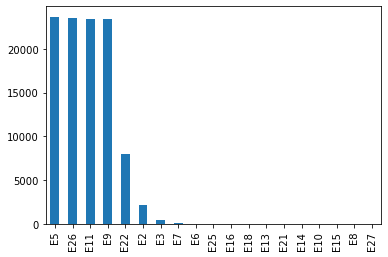

In [9]:
feature_df['EventId'].value_counts().plot(kind='bar')

In [10]:
label_df = pd.read_csv(label_path)
print(label_df.shape)
label_df.head()

(575061, 2)


,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly
3,blk_-9073992586687739851,Normal
4,blk_7854771516489510256,Normal


In [11]:
# Check for missing values
print( label_df.isnull().any().sum() )

0


## Data Preprocessing

In [12]:
# load and spilt HDFS logs into training (70%) and test dataset (30%)
(x_train, y_train), (x_test, y_test) = dataloader.load_HDFS(feature_path,
                                                            label_path,
                                                            window='session', 
                                                            train_ratio=0.7,
                                                            split_type='uniform')

====== Input data summary ======
Loading data/HDFS_100k.log_structured.csv
219 94
Total: 7940 instances, 313 anomaly, 7627 normal
Train: 5557 instances, 219 anomaly, 5338 normal
Test: 2383 instances, 94 anomaly, 2289 normal



In [13]:
x_train[0]

['E22',
 'E5',
 'E5',
 'E5',
 'E26',
 'E26',
 'E11',
 'E9',
 'E11',
 'E9',
 'E26',
 'E11',
 'E9']

In [14]:
# Preprocess and vectorise dataset for model training and testing
feature_extractor = preprocessing.FeatureExtractor()
x_train_transformed = feature_extractor.fit_transform(x_train, term_weighting='tf-idf')
x_test_transformed = feature_extractor.transform(x_test)

====== Transformed train data summary ======
Train data shape: 5557-by-16

====== Transformed test data summary ======
Test data shape: 2383-by-16



In [15]:
x_train_transformed[0]

array([-1.79956050e-12, -5.39868150e-12,  4.78878298e-02,  4.73393336e-02,
        4.78878298e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])